### Importing all important libraries

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

### Read and boxplot data

In [62]:
df = pd.read_csv("penguins.csv")
df = df.dropna()             # Delete missing data
df = df.drop("sex", axis=1)  # Dropping sex because we want K means clustering and not K mode clustering

df.boxplot()
df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0


### Dropping outliers (see boxplot)

In [49]:
df = df.drop(df[df["flipper_length_mm"] > 1000].index)
df = df.drop(df[df["flipper_length_mm"] < 0].index)

### Scaling

In [50]:
df = ( (df - df.min()) / (df.max() - df.min()) ) * 9 + 1

df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,3.290909,7.000000,2.372881,3.625
1,3.421818,5.607143,3.135593,3.750
2,3.683636,6.250000,4.508475,2.375
4,2.505455,7.642857,4.203390,2.875
5,3.356364,9.035714,3.745763,3.375


# STEP 1
    Pick k random centroids for the k clusters (picking k random rows)

In [51]:
def init_random_cluster_centroids(df, k):
    return df.sample(n=k).reset_index(drop=True).T

# STEP 2
    Calculate euclidean distance from the data points to the centroids of the clusters

In [52]:
def get_cluster_label(df, cluster_centroid):
    distances = cluster_centroid.apply(lambda x: np.sqrt(np.square(df - x).sum(axis=1)) )  # Euclidean distance
    distances = distances.idxmin(axis=1)
    return distances

# STEP 3
    Update centroids of clusters based on the assigned data points to those clusters (Geometric mean)

In [53]:
def new_cluster_centroid(df, cluster_label):
    return df.groupby(cluster_label).apply(lambda x: np.exp(np.log(x).mean())).T

# STEP 4
    Repeat until centroids don't change anymore or max iterations is reached

In [54]:
cluster_count = 5 # k
old_cluster_centroids = pd.DataFrame()
current_cluster_centroids = init_random_cluster_centroids(df, cluster_count)

for i in range(1, cluster_count+1):
    current_cluster_centroids = init_random_cluster_centroids(df, i)
    old_cluster_centroids = pd.DataFrame()

    while(not current_cluster_centroids.equals(old_cluster_centroids)):
        
        old_cluster_centroids = current_cluster_centroids
        cluster_labels = get_cluster_label(df, current_cluster_centroids)
        current_cluster_centroids = new_cluster_centroid(df, cluster_labels)

current_cluster_centroids # Result

,0,1,2,3,4
culmen_length_mm,6.632508,3.522110,6.571642,2.841198,5.296558
culmen_depth_mm,3.687870,7.508678,6.769745,5.655438,2.119730
flipper_length_mm,8.489323,4.203149,4.744888,3.115761,7.155094
body_mass_g,7.877114,4.322221,3.618049,2.594092,5.863034


# Elbow method to find the best K

In [55]:
def calculate_wcss(df, cluster_centroid): # With-in sum of squares
    distances = cluster_centroid.apply(lambda x: np.sqrt(np.square(df - x).sum(axis=1)))
    distances = distances.min(axis=1)
    return np.sum(distances.values)
    

In [56]:
def get_wcss_list(max_k):  # Elbow method
    wcss_list = []
    
    for i in range(1, max_k+1):
        current_cluster_centroids = init_random_cluster_centroids(df, i)
        old_cluster_centroids = pd.DataFrame()

        while(not current_cluster_centroids.equals(old_cluster_centroids)):
            old_cluster_centroids = current_cluster_centroids
            cluster_labels = get_cluster_label(df, current_cluster_centroids)
            current_cluster_centroids = new_cluster_centroid(df, cluster_labels)

        wcss_list.append(calculate_wcss(df, current_cluster_centroids))

    return wcss_list

### Compare to Sklearn

In [57]:
def sklearn_get_wcss_list(max_k):
    sklearn_wcss_list = []
    for i in range(1, max_k+1):
        kMeans = KMeans(n_clusters=i, init="k-means++")
        kMeans.fit(df)
        sklearn_wcss_list.append(kMeans.inertia_)
    return sklearn_wcss_list

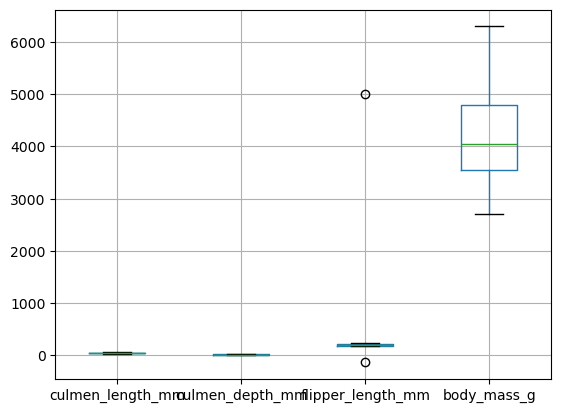

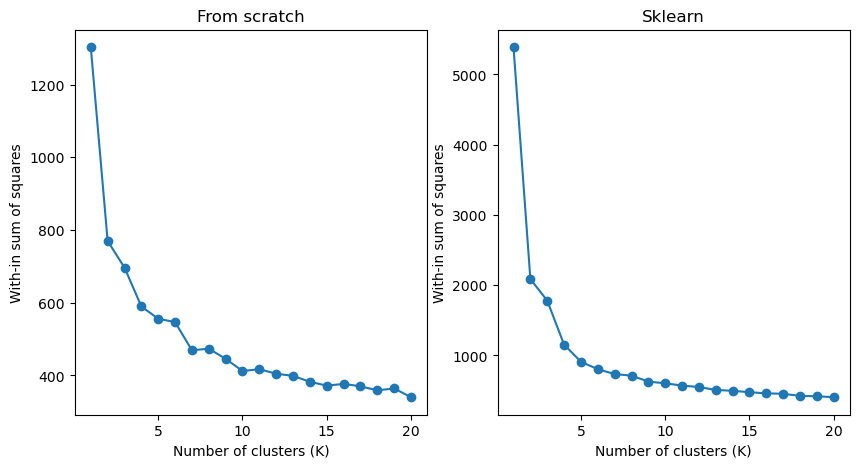

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

max_k = 20

ax[0].set_title("From scratch")
ax[0].set_xlabel("Number of clusters (K)")
ax[0].set_ylabel("With-in sum of squares")
ax[0].plot(np.arange(1, max_k+1), get_wcss_list(max_k), marker="o")

ax[1].set_title("Sklearn")
ax[1].set_xlabel("Number of clusters (K)")
ax[1].set_ylabel("With-in sum of squares")
ax[1].plot(np.arange(1, max_k+1), sklearn_get_wcss_list(max_k), marker="o")

plt.show()